In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
filepath = 'C:/Users/phill/INFO698-Capstone/Anonymized Dataset for Info Science MS.csv'
data = pd.read_csv(filepath)

In [3]:
# Drop all records that do not include a Term GPA, as this will be our response variable for all models
data = data.dropna(subset = ['TermGPA'])

In [98]:
# Saving code that found outliers in the data set, but ones that we ultimately decided to keep in the data
# data.loc[(data['UnitsPassedincludedinGPA'] == 0) & (data['UnitsPassednotincludedinGPA'] == 0) & (data['TermGPA'] > 0)]
# data.loc[(data['UnitsPassedincludedinGPA'] == 0) & (data['UnitsPassednotincludedinGPA'] > 0)]
# data.loc[(data['UnitsPassedincludedinGPA'] == 0) & (data['UnitsPassednotincludedinGPA'] == 0) & (data['TermGPA'] == 0)]

In [4]:
# Group ages into ranges for categorical scoring
data['AgeGroups'] = pd.cut(data['Age'], bins=[0,24,39,59,100], labels=['<25','25-39','40-59','60+'])
# data['AgeGroups'].value_counts()

In [6]:
# Create a weighted GPA value to give more weight to those taking more classes (may not use this)
# data['WeightedGPA'] = data['TermGPA'] * data['UnitsPassedincludedinGPA']
# data[['TermGPA', 'UnitsPassedincludedinGPA', 'WeightedGPA']]

In [5]:
# Create zscore values for each categorical field to feed into the model in addition to one-hot encoding of membership in each group
data['zFirstGen'] = data.groupby('FirstGenerationFlag', observed=True)['TermGPA'].transform(zscore)
data['zAge'] = data.groupby('AgeGroups', observed=True)['TermGPA'].transform(zscore)
data['zGender'] = data.groupby('Gender', observed=True)['TermGPA'].transform(zscore)
data['zMilitary'] = data.groupby('PrimaryMilitaryAffiliation', observed=True)['TermGPA'].transform(zscore)
data['zCollege'] = data.groupby('College', observed=True)['TermGPA'].transform(zscore)
data['zCollege'] = data['zCollege'].fillna(0) # Corrects issue of only 2 observations from one of the colleges producing NaN
data['zAcademicCareer'] = data.groupby('AcademicCareer', observed=True)['TermGPA'].transform(zscore)
data['zAcademicLevel'] = data.groupby('AcademicLevelEndofTerm', observed=True)['TermGPA'].transform(zscore)
data['zFullTimePartTime'] = data.groupby('UAFullTimePartTime', observed=True)['TermGPA'].transform(zscore)
data['zClassesEnrolled'] = data.groupby('NumberofClassesEnrolled', observed=True)['TermGPA'].transform(zscore)

In [ ]:
# Initial basic regression model

In [5]:
# Set the y response variable to the TermGPA
y = data['TermGPA']

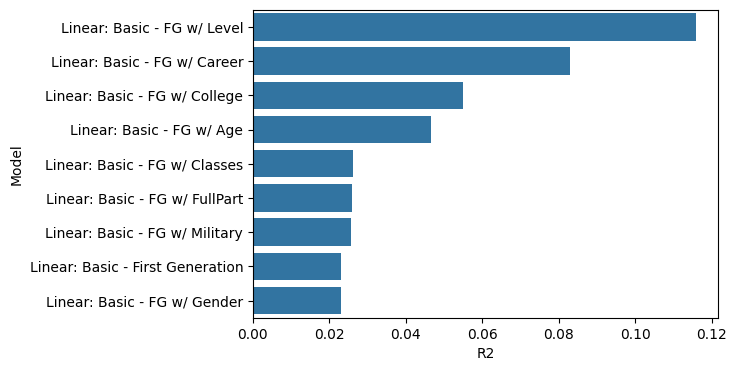

In [13]:
# Run basic regression on the First Generation Flag with each feature individually
model_results = []
feature_sets = [
    ('Linear: Basic', 'First Generation', ['FirstGenerationFlag']),
    ('Linear: Basic', 'FG w/ College', ['FirstGenerationFlag', 'College']),
    ('Linear: Basic', 'FG w/ Age', ['FirstGenerationFlag', 'AgeGroups']),
    ('Linear: Basic', 'FG w/ Military', ['FirstGenerationFlag', 'PrimaryMilitaryAffiliation']),
    ('Linear: Basic', 'FG w/ Level', ['FirstGenerationFlag', 'AcademicLevelEndofTerm']),
    ('Linear: Basic', 'FG w/ Career', ['FirstGenerationFlag', 'AcademicCareer']),
    ('Linear: Basic', 'FG w/ Gender', ['FirstGenerationFlag', 'Gender']),
    ('Linear: Basic', 'FG w/ FullPart', ['FirstGenerationFlag', 'UAFullTimePartTime']),
    ('Linear: Basic', 'FG w/ Classes', ['FirstGenerationFlag', 'NumberofClassesEnrolled'])    
]
results_linear_individual = feature_set_models(feature_sets, model_results)
bar(results_linear_individual)

# Results show that the following features do not add any increase in GPA prediction to the First Generation Flag:
#    Gender, PrimaryMilitaryAffiliation, UAFullTimePartTime, NumberofClassesEnrolled
# The following features all increase the R^2 when combined with FirstGen:
#    AcademicLevelEndofTerm, AcademicCareer, College, AgeGroups

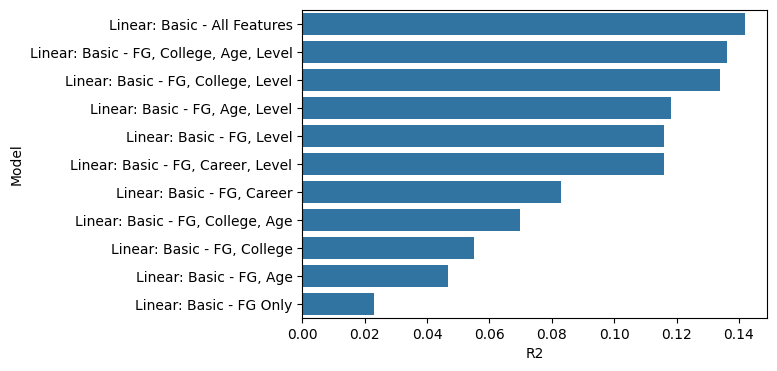

In [16]:
# Run different combinations of the found relevant features
model_results = []
feature_sets = [
    ('Linear: Basic', 'FG Only', ['FirstGenerationFlag']),
    ('Linear: Basic', 'FG, College', ['FirstGenerationFlag', 'College']),
    ('Linear: Basic', 'FG, Age', ['FirstGenerationFlag', 'AgeGroups']),
    ('Linear: Basic', 'FG, Level', ['FirstGenerationFlag', 'AcademicLevelEndofTerm']),
    ('Linear: Basic', 'FG, Career', ['FirstGenerationFlag', 'AcademicCareer']),
    ('Linear: Basic', 'FG, Career, Level', ['FirstGenerationFlag', 'AcademicCareer', 'AcademicLevelEndofTerm']),
    ('Linear: Basic', 'FG, Age, Level', ['FirstGenerationFlag', 'AcademicLevelEndofTerm', 'AgeGroups']),
    ('Linear: Basic', 'FG, College, Level', ['FirstGenerationFlag', 'AcademicLevelEndofTerm', 'College']),
    ('Linear: Basic', 'FG, College, Age', ['FirstGenerationFlag', 'College', 'AgeGroups']),
    ('Linear: Basic', 'FG, College, Age, Level', ['FirstGenerationFlag', 'College', 'AgeGroups', 'AcademicLevelEndofTerm']),
    ('Linear: Basic', 'All Features', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled'])
]
results_linear_combos = feature_set_models(feature_sets, model_results)
bar(results_linear_combos)

# Results show the following:
#    Addition of AcademicCareer adds nothing to the performance of AcademicLevelEndofTerm, so this appears to be redundant information
#    AcademicLevelEndofTerm and College both add large performance gains
#    AgeGroups adds a small amount, but still worth having it in place
#    The inclusion of all the other non-relevant features do add a small amount of performance over the core 3

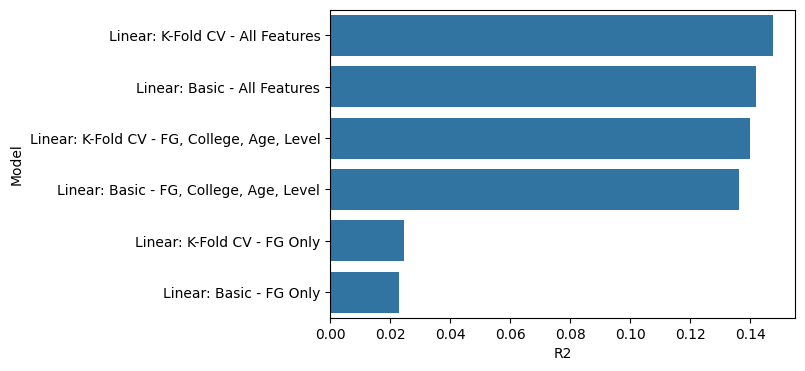

In [17]:
# Take the key groupings and run both basic linear regression and K-Fold Cross Validation to compare model performance
model_results = []
feature_sets = [
    ('Linear: Basic', 'FG Only', ['FirstGenerationFlag']),
    ('Linear: Basic', 'FG, College, Age, Level', ['FirstGenerationFlag', 'College', 'AgeGroups', 'AcademicLevelEndofTerm']),
    ('Linear: Basic', 'All Features', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']),
    ('Linear: K-Fold CV', 'FG Only', ['FirstGenerationFlag']),
    ('Linear: K-Fold CV', 'FG, College, Age, Level', ['FirstGenerationFlag', 'College', 'AgeGroups', 'AcademicLevelEndofTerm']),
    ('Linear: K-Fold CV', 'All Features', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled'])
]
results_linear_cvcompare = feature_set_models(feature_sets, model_results)
bar(results_linear_cvcompare)

# Results show the following:
#    Addition of AcademicCareer adds nothing to the performance of AcademicLevelEndofTerm, so this appears to be redundant information
#    AcademicLevelEndofTerm and College both add large performance gains
#    AgeGroups adds a small amount, but still worth having it in place
#    The inclusion of all the other non-relevant features do add a small amount of performance over the core 3

In [49]:
# Calculate the percent improvement in R2 from adding K-Fold Cross Validation
r2_cv = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: K-Fold CV - FG Only')]['R2'].item()
r2_basic = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: Basic - FG Only')]['R2'].item()
cv_gain_firstgen = (r2_cv - r2_basic) / r2_basic

r2_cv = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: K-Fold CV - FG, College, Age, Level')]['R2'].item()
r2_basic = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: Basic - FG, College, Age, Level')]['R2'].item()
cv_gain_core = (r2_cv - r2_basic) / r2_basic

r2_cv = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: K-Fold CV - All Features')]['R2'].item()
r2_basic = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: Basic - All Features')]['R2'].item()
cv_gain_all = (r2_cv - r2_basic) / r2_basic

print("Improvement in R2 from adding K-Fold Cross Validation to Basic Linear Regression")
print(f"First Generation Only: \t\t{cv_gain_firstgen:+.2f}%")
print(f"College, Age & Academic Level: \t{cv_gain_core:+.2f}%")
print(f"All Features: \t\t\t{cv_gain_all:+.2f}%")

Improvement in R2 from adding K-Fold Cross Validation to Basic Linear Regression
First Generation Only: 		+0.06%
College, Age & Academic Level: 	+0.03%
All Features: 			+0.04%


In [52]:
# Calculate the percent improvement in R2 from adding K-Fold Cross Validation
r2_cv_firstgen = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: K-Fold CV - FG Only')]['R2'].item()
r2_cv_core = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: K-Fold CV - FG, College, Age, Level')]['R2'].item()
r2_cv_all = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: K-Fold CV - All Features')]['R2'].item()
r2_gain_core = (r2_cv_core - r2_cv_firstgen) / r2_cv_firstgen
r2_gain_all = (r2_cv_all - r2_cv_core) / r2_cv_core

print("Improvement in R2 from adding features within K-Fold Cross Validation")
print(f"First Generation Only: \t\t{r2_cv_firstgen:.2f}")
print(f"College, Age & Academic Level: \t{r2_cv_core:.2f}\t{r2_gain_core:+.2f}%")
print(f"All Features: \t\t\t{r2_cv_all:.2f}\t{r2_gain_all:+.2f}%")

Improvement in R2 from adding features within K-Fold Cross Validation
First Generation Only: 		0.02
College, Age & Academic Level: 	0.14	+4.69%
All Features: 			0.15	+0.06%


In [6]:
# Function for Basic Linear Regression model w/ one-hot encoding of categorical features
def linear_basic (X, y):
    model = LinearRegression()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314)
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_train_encoded = encoder.fit_transform(X_train)
    X_test_encoded = encoder.transform(X_test)

    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(X_test_encoded)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return r2, rmse

In [7]:
# Function for Linear Regression w/ K-Fold Cross Validation
# Perform K-Fold Cross Validation using 10 folds to get the most accurate predictive power of the model
# Use a column transformer inside a pipeline to ensure the one-hot encoding for categorical features is only applied to the training set

def linear_cv (X, y):
    model = LinearRegression()
    scoring_metrics = ['r2', 'neg_mean_squared_error']

    preprocessor = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False), slice(0, None)))
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])

    cross_validation = KFold(n_splits=10, shuffle=True, random_state=314)
    cv_scores = cross_validate(full_pipeline, X, y, cv=cross_validation, scoring=scoring_metrics)

    r2 = np.mean(cv_scores['test_r2'])
    rmse = np.sqrt(-np.mean(cv_scores['test_neg_mean_squared_error']))

    return r2, rmse

In [8]:
def feature_set_models(feature_sets, results):
    for model_type, name, features in feature_sets:
        X = data[features]

        if model_type == 'Linear: Basic':
            r2, rmse = linear_basic(X, y)
        elif model_type == 'Linear: K-Fold CV':
            r2, rmse = linear_cv(X, y)

        results.append({
            'Model': model_type + " - " + name,
            'R2': r2,
            'RMSE': rmse
        })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='R2', ascending=False)
    return(results_df)

In [9]:
# Function for scatterplot of R2 and RMSE values
def scatter(data):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        data=data,
        x='R2',
        y='RMSE',
        hue='Model',
        s=150,
        palette='deep'
    )
    plt.show()

In [10]:
# Function for scatterplot of R2 and RMSE values
def bar(data):
    plt.figure(figsize=(6, 4))
    sns.barplot(data=data, x='R2', y='Model')
    plt.show()